<a href="https://colab.research.google.com/github/rouyu0405/IAT360/blob/main/computer_vision_project_New_Add%20failed%20cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Project - Fall Detection for Seniors**
This project is to to identify if seniors are in a safe position. We would be training a computer vision model to detect if seniors have fallen at home. This is important in guaranteeing that seniors receive help as soon as possible; the faster fallen seniors receive help, the higher the possibility of recovery there is.

**Prepration**

Import YOLOv8

In [14]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/112.6 GB disk)


In [15]:
from ultralytics import YOLO

Import Libraries

In [16]:
import os, shutil, yaml

Connect to Google Drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Preprocessing**

In [21]:
DATASET_PATH = "/content/drive/MyDrive/360_Project/Datasets"

# These should match your folder names in Drive
ARCHIVE_PATH = os.path.join(DATASET_PATH, "fall_dataset")   # train + val
FALL_PATH = os.path.join(DATASET_PATH, "FALL")         # test

# New merged dataset location (in Colab)
MERGED_PATH = "/content/drive/MyDrive/360_Project/Datasets/fall_dataset"
os.makedirs(MERGED_PATH, exist_ok=True)


# Expected subfolders
train_img_dir = f"{ARCHIVE_PATH}/fall_dataset/images/train"
val_img_dir = f"{ARCHIVE_PATH}/fall_dataset/images/val"
train_lbl_dir = f"{ARCHIVE_PATH}/fall_dataset/labels/train"
val_lbl_dir = f"{ARCHIVE_PATH}/fall_dataset/labels/val"

# Test from FALL dataset
test_img_dir = f"{FALL_PATH}/valid/images"
test_lbl_dir = f"{FALL_PATH}/valid/labels"

# Create YOLO folder structure
final_dirs = [
    f"{MERGED_PATH}/images/train",
    f"{MERGED_PATH}/images/val",
    f"{MERGED_PATH}/images/test",
    f"{MERGED_PATH}/labels/train",
    f"{MERGED_PATH}/labels/val",
    f"{MERGED_PATH}/labels/test"
]
for d in final_dirs:
    os.makedirs(d, exist_ok=True)

# Helper function to copy files
def copy_all(src, dst):
    if os.path.exists(src):
        for f in os.listdir(src):
            shutil.copy(os.path.join(src, f), dst)

copy_all(train_img_dir, f"{MERGED_PATH}/images/train")
copy_all(val_img_dir, f"{MERGED_PATH}/images/val")
copy_all(test_img_dir, f"{MERGED_PATH}/images/test")

copy_all(train_lbl_dir, f"{MERGED_PATH}/labels/train")
copy_all(val_lbl_dir, f"{MERGED_PATH}/labels/val")
copy_all(test_lbl_dir, f"{MERGED_PATH}/labels/test")


yaml_path = os.path.join(MERGED_PATH, "data.yaml")

yaml_data = {
    "path": MERGED_PATH,
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "nc": 3,
    "names": ["fallen", "sitting", "standing"]
}

with open(yaml_path, "w") as f:
    yaml.dump(yaml_data, f, sort_keys=False)

!cat "$yaml_path"

path: /content/drive/MyDrive/360_Project/Datasets/fall_dataset
train: images/train
val: images/val
test: images/test
nc: 3
names:
- fallen
- sitting
- standing


## **Training**

In [22]:
!yolo train \
  task=detect \
    data="$yaml_path" \
    model=yolov8n.pt \
    epochs=50 \
    imgsz=640 \
    batch=16 \
    name="fall_yolov8n_baseline"

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/360_Project/Datasets/fall_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fall_yolov8n_baseline2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

## **Hyperparameter**

In [23]:
hyp_yaml = """
lr0: 0.005       # lower initial learning rate
lrf: 0.1
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 15.0
translate: 0.15
scale: 0.5
shear: 0.2
flipud: 0.5
fliplr: 0.5
mosaic: 1.0
mixup: 0.2
"""

with open("tuned_hyp.yaml", "w") as f:
    f.write(hyp_yaml)

print("✅ Custom hyperparameters saved to tuned_hyp.yaml")

with open("tuned_hyp.yaml") as f:
    hyp_dict = yaml.safe_load(f)

model = YOLO("yolov8n.pt")
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name="fall_yolov8n_tuned",
    **hyp_dict
  )

✅ Custom hyperparameters saved to tuned_hyp.yaml
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/360_Project/Datasets/fall_dataset/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fall_yolov8n_tuned, nbs=64, nms=False, opset=None,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6ddc85d3a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## **Evaluate**

In [26]:
!yolo val task=detect model="runs/detect/fall_yolov8n_baseline/weights/best.pt" data="$yaml_path"
!yolo val task=detect model="runs/detect/fall_yolov8n_tuned/weights/best.pt" data="$yaml_path"

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 22.7±16.1 MB/s, size: 55.4 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1bRDoglAXKiYpWkFISBu30kGheB2g6-uX/360_Project/Datasets/fall_dataset/labels/val.cache... 111 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 111/111 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.4it/s 2.9s
                   all        111        114      0.773      0.793      0.829      0.582
                fallen         72         72      0.832      0.903      0.922      0.664
               sitting         22         23      0.763      0.739        0.8      0.538
              standing         19         19      0.724      0.737      0.766      0.544
Speed: 3.7ms preprocess, 12.1ms inference, 0.0ms loss, 2

## **Predict**

In [27]:
TEST_IMAGES = f"{MERGED_PATH}/images/test"

!yolo predict task=detect model="runs/detect/fall_yolov8n_baseline/weights/best.pt" source="$TEST_IMAGES" save=True name="baseline_preds"
!yolo predict task=detect model="runs/detect/fall_yolov8n_tuned/weights/best.pt" source="$TEST_IMAGES" save=True name="tuned_preds"

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_02_01_jpg.rf.15002eb37ac71dbe6956e583e63ddc8a.jpg: 640x576 1 fallen, 38.2ms
image 2/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_09_01_jpeg.rf.2dc3935abd58cc89697787f361f985a2.jpg: 640x512 2 fallens, 42.3ms
image 3/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_10_01_jpg.rf.7a47d025513afae31e1d06907556ffed.jpg: 640x544 (no detections), 38.3ms
image 4/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_13_01_png.rf.af23a7b107ce509e04f880490cd253ed.jpg: 448x640 1 fallen, 36.4ms
image 5/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_15_01_jpg.rf.455d643274b72a0b837c295c50a05df2.jpg: 448x640 1 fallen, 6.1ms
image 6/18 /content/drive/MyDrive

## **Results**

📈 Baseline Training Results


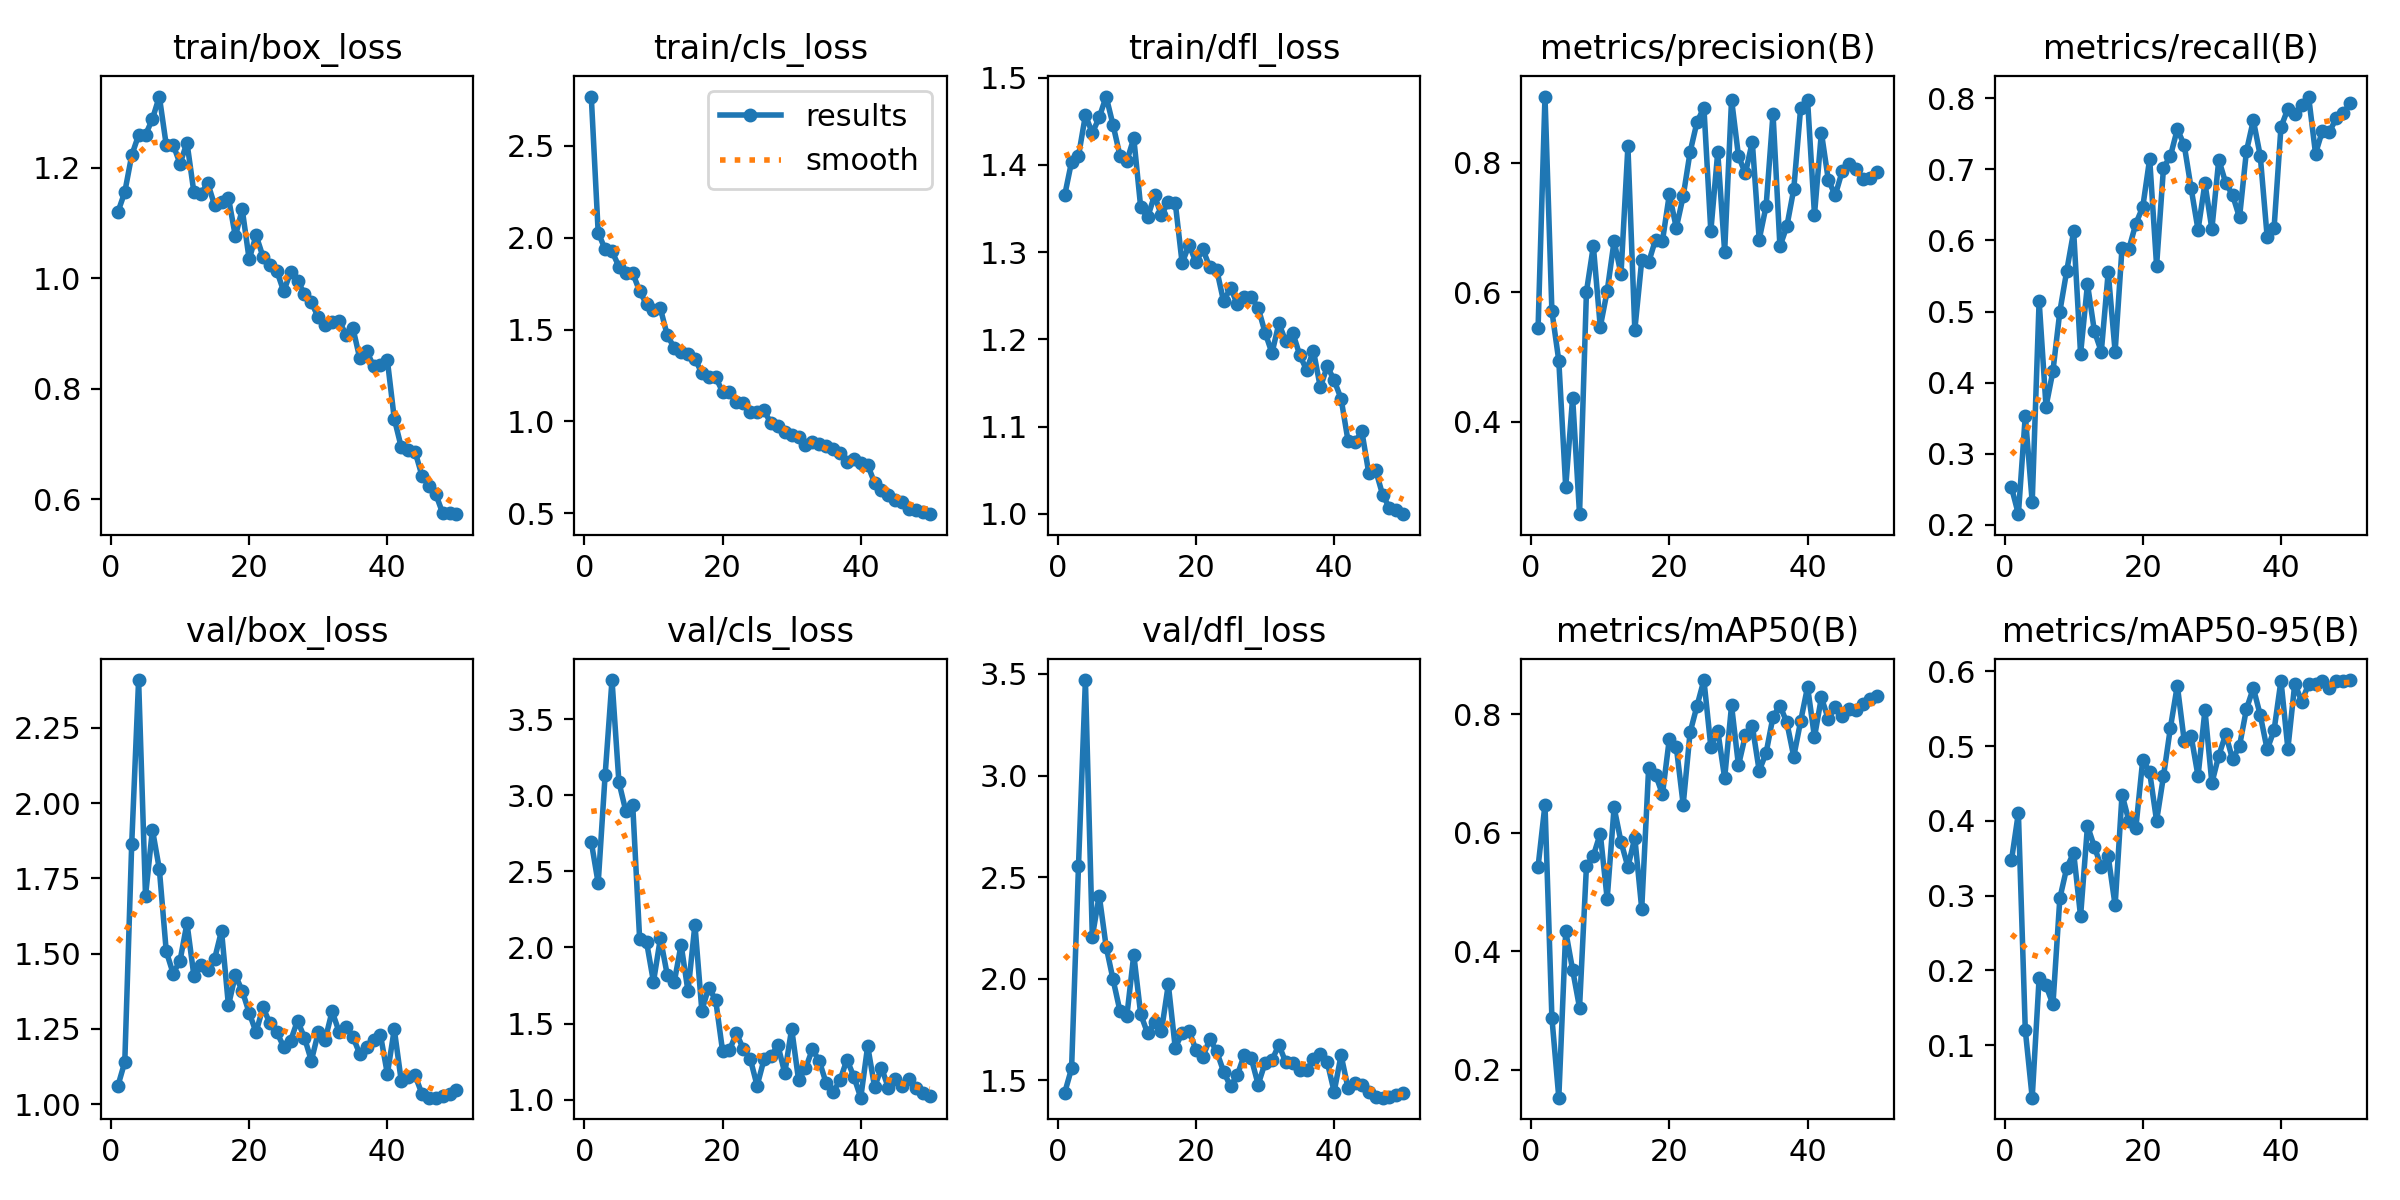

📈 Tuned Training Results


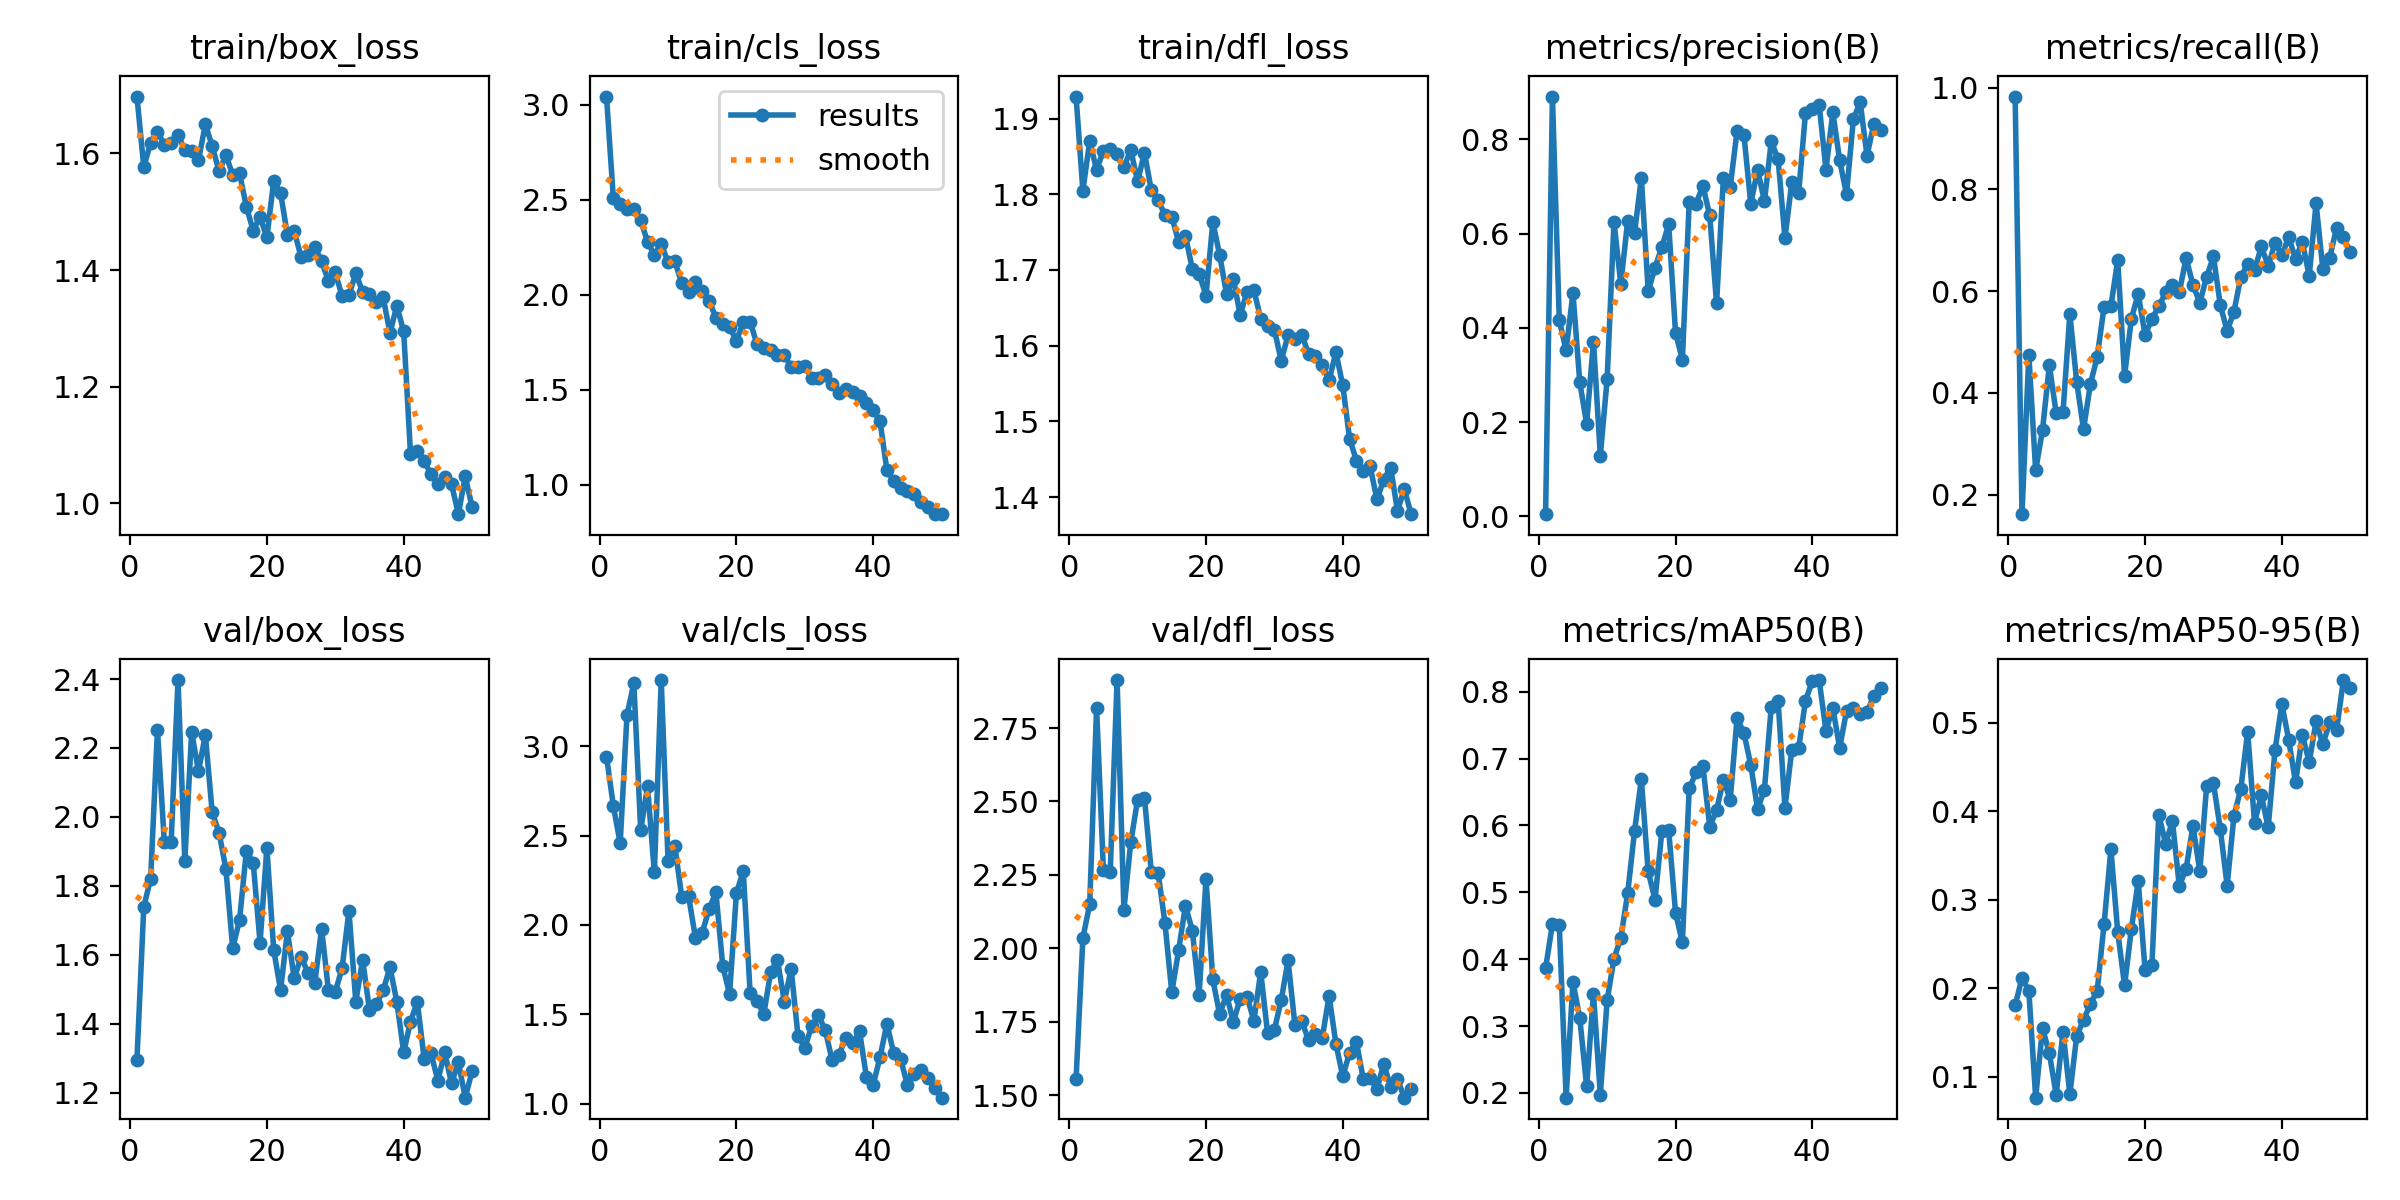

In [28]:
from IPython.display import Image, display

print("📈 Baseline Training Results")
display(Image(filename='runs/detect/fall_yolov8n_baseline/results.png'))

print("📈 Tuned Training Results")
display(Image(filename='runs/detect/fall_yolov8n_tuned/results.png'))

## **Evaluation Metrics**

In [29]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.2±0.6 ms, read: 19.1±27.2 MB/s, size: 64.1 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1bRDoglAXKiYpWkFISBu30kGheB2g6-uX/360_Project/Datasets/fall_dataset/labels/val.cache... 111 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 111/111 100.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.3it/s 3.1s
                   all        111        114       0.82      0.706      0.786       0.54
                fallen         72         72      0.943      0.861      0.959      0.664
               sitting         22         23      0.742      0.783      0.778      0.529
              standing         19         19      0.775      0.474      0.622      0.427
Speed: 4.7ms preprocess, 11.6ms inference, 0.0ms loss,

np.float64(0.7058013390965336)

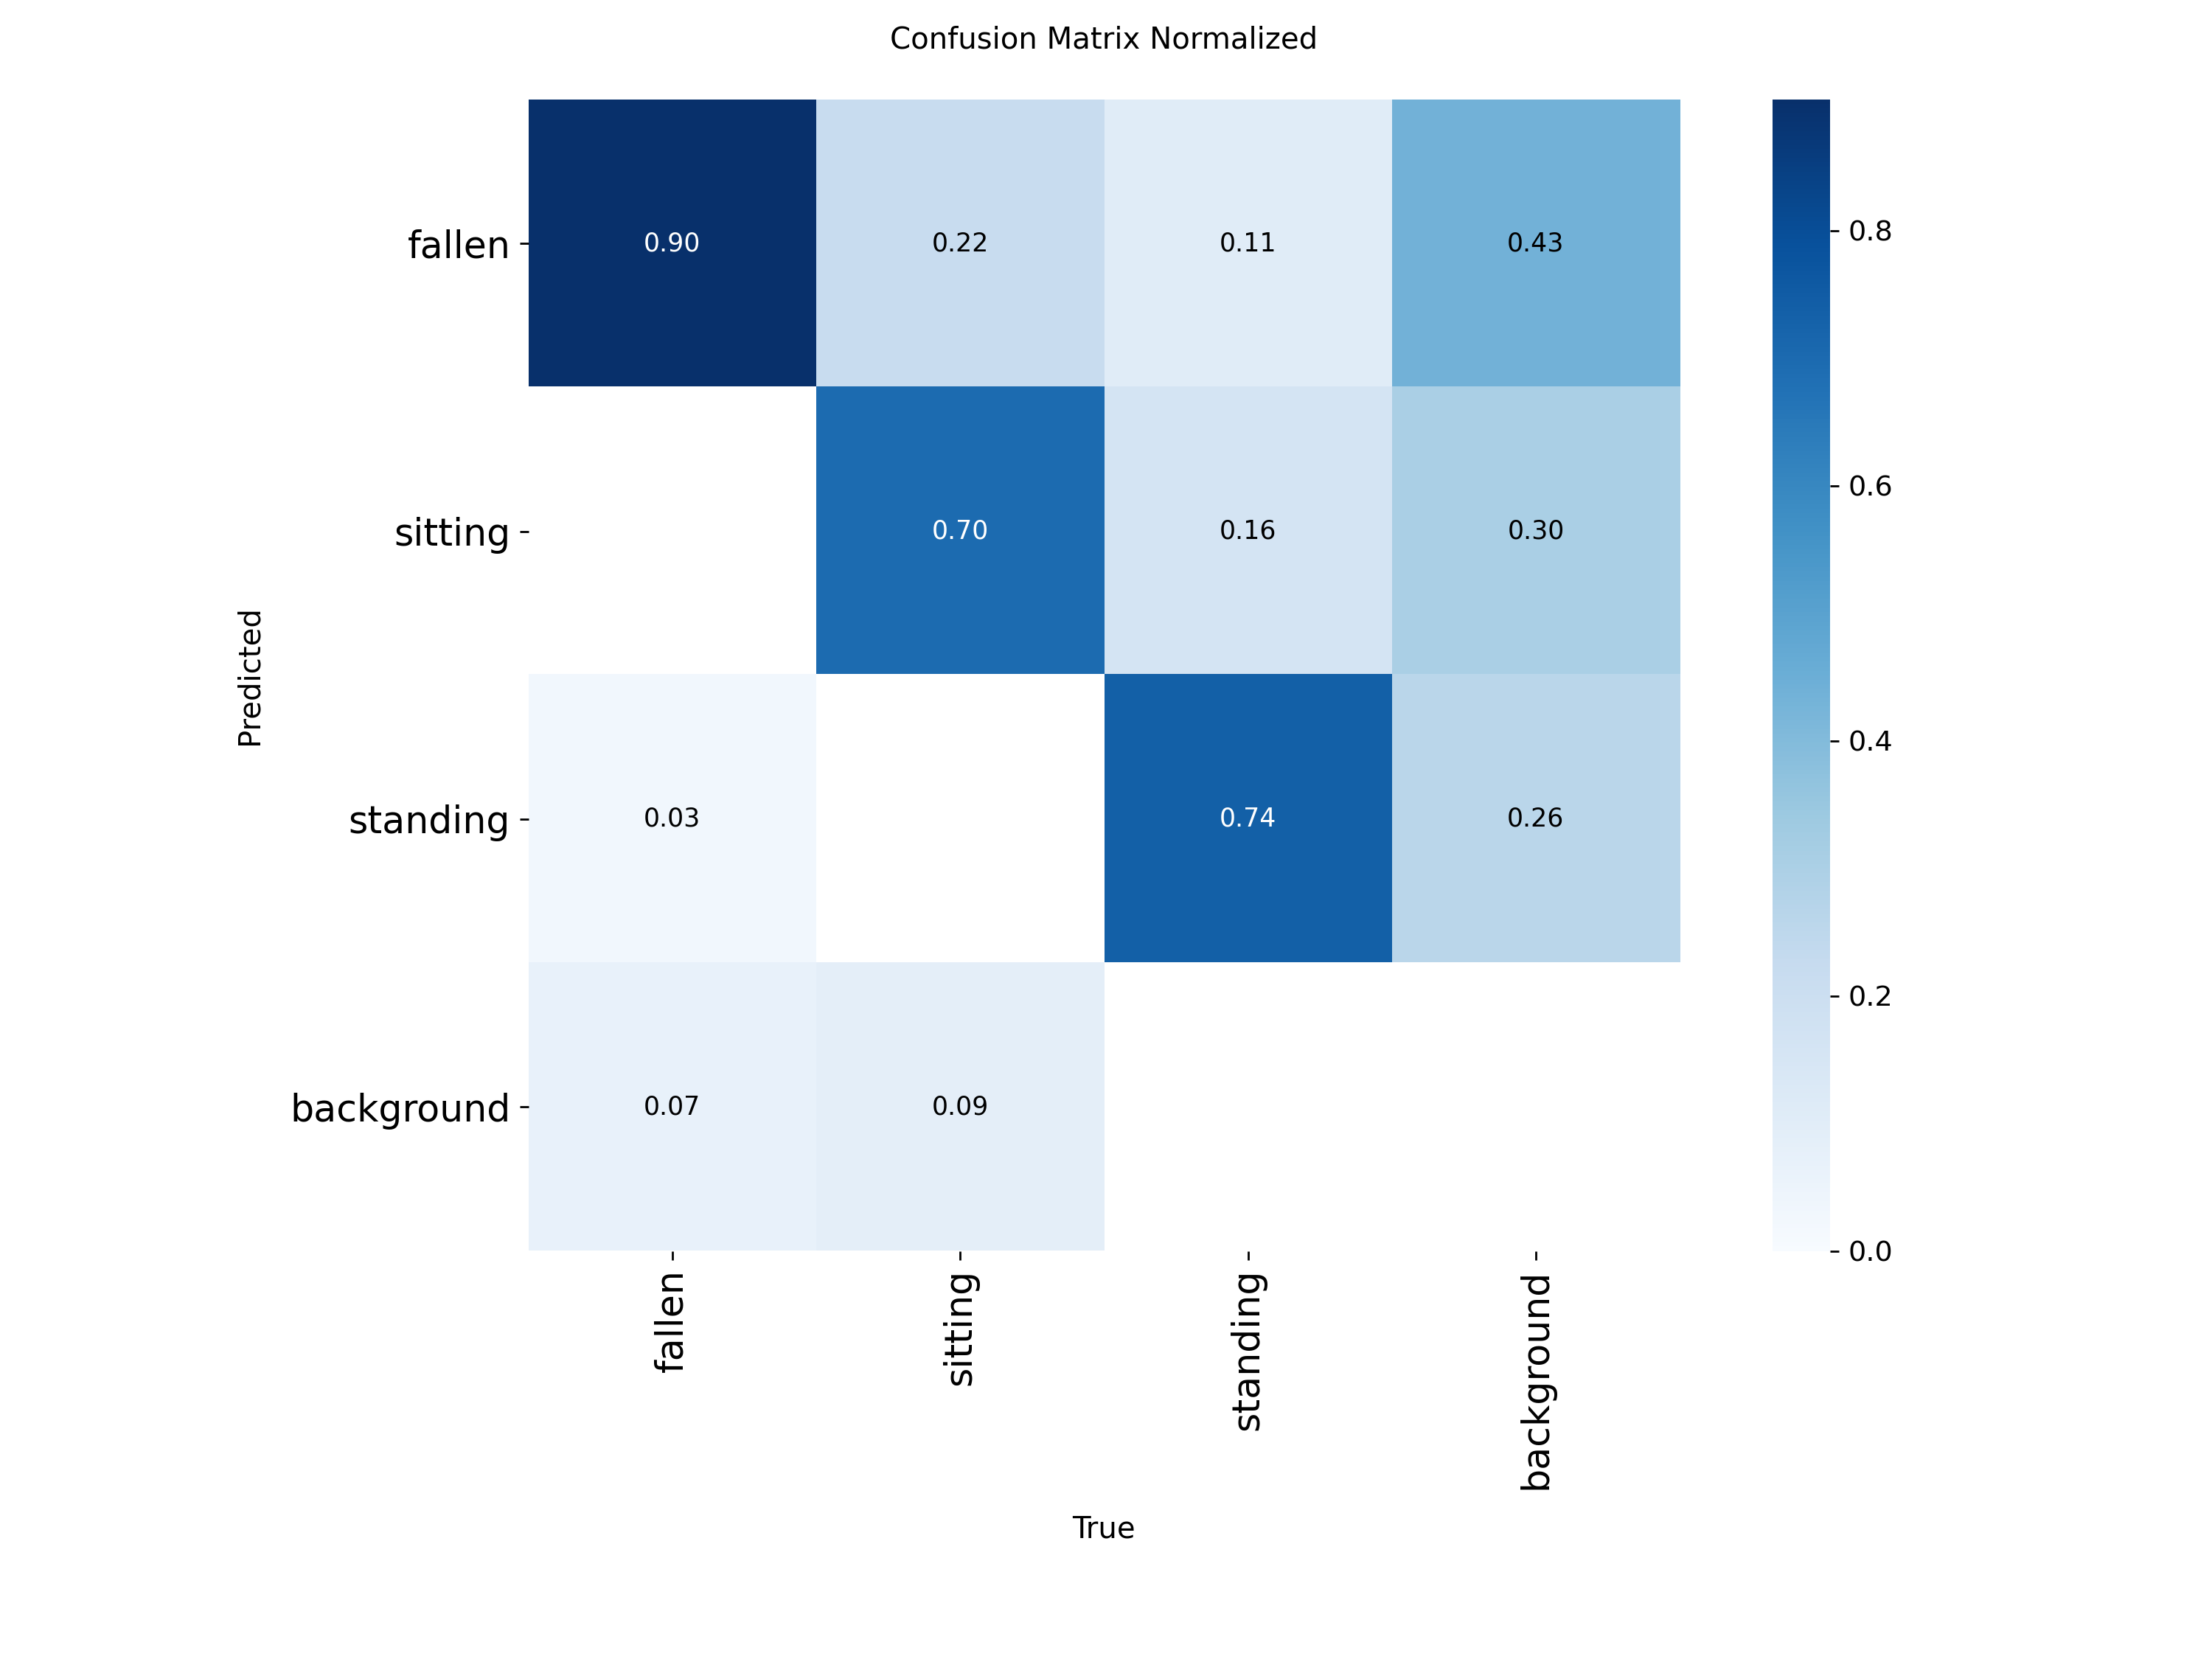

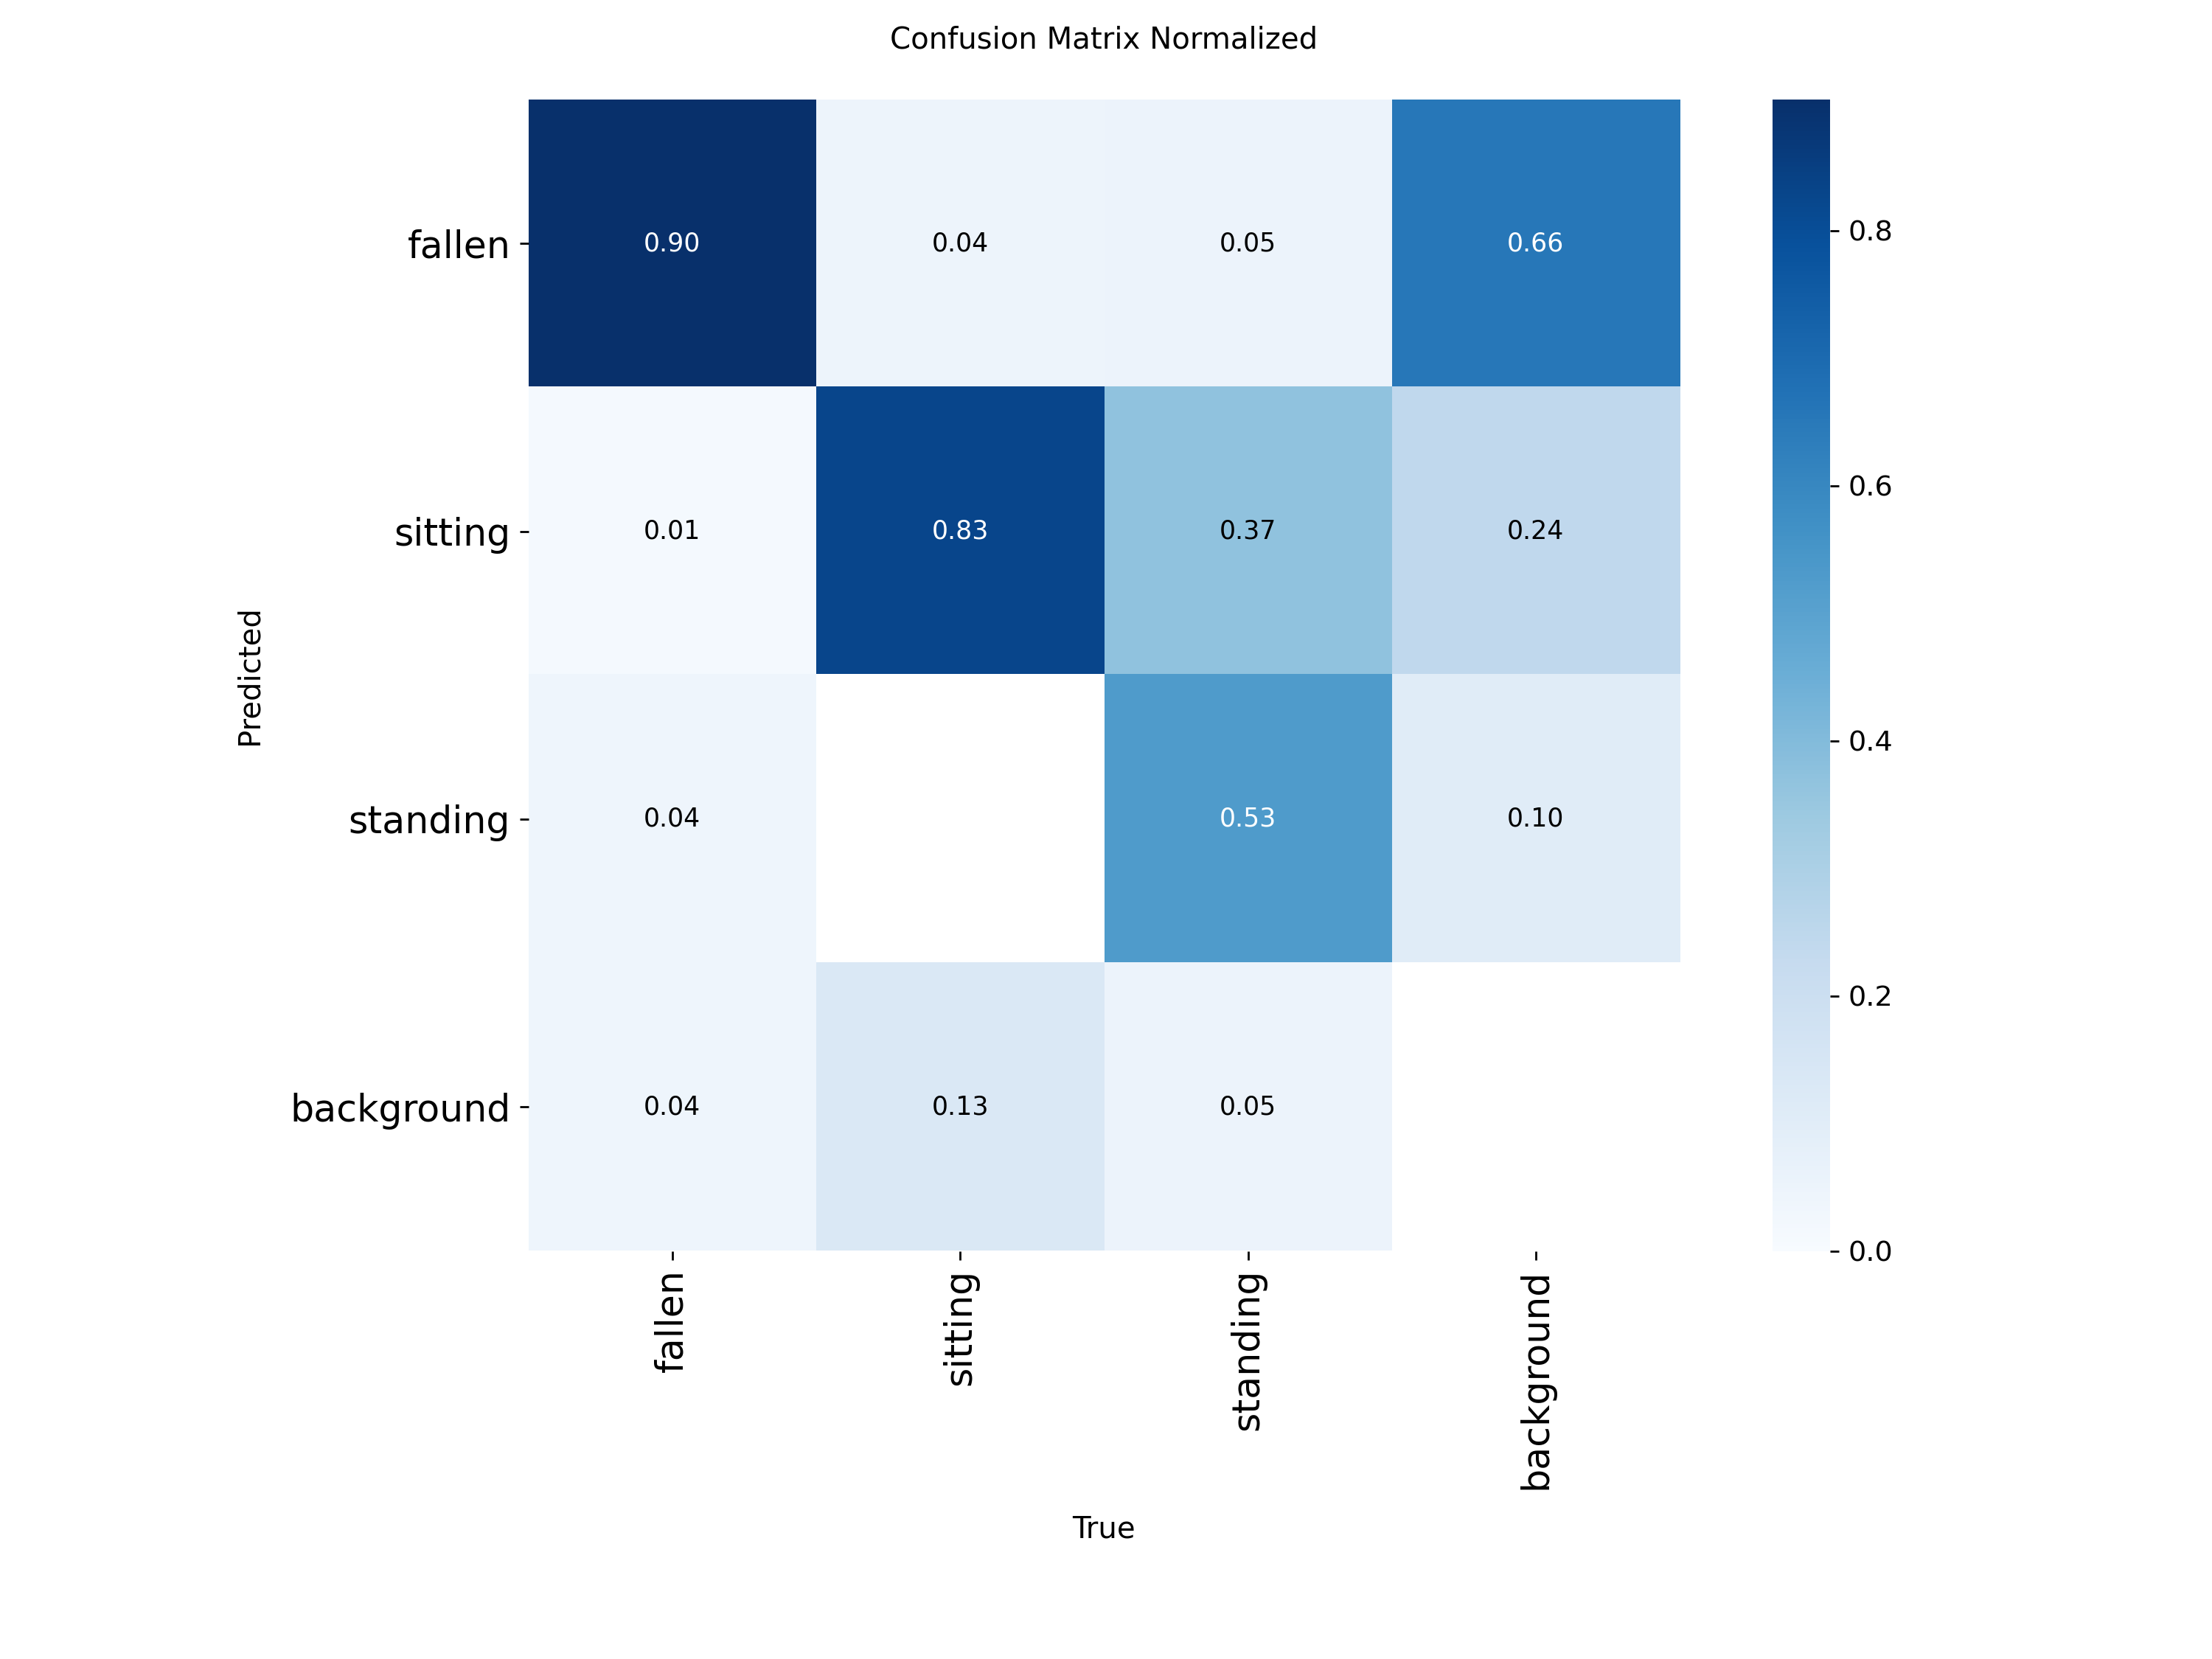

In [33]:
%matplotlib inline
from IPython.display import display
from PIL import Image

display(Image.open('/content/runs/detect/fall_yolov8n_baseline/confusion_matrix_normalized.png'))
display(Image.open('/content/runs/detect/fall_yolov8n_tuned/confusion_matrix_normalized.png'))

## **Precision, Recall, Curves**

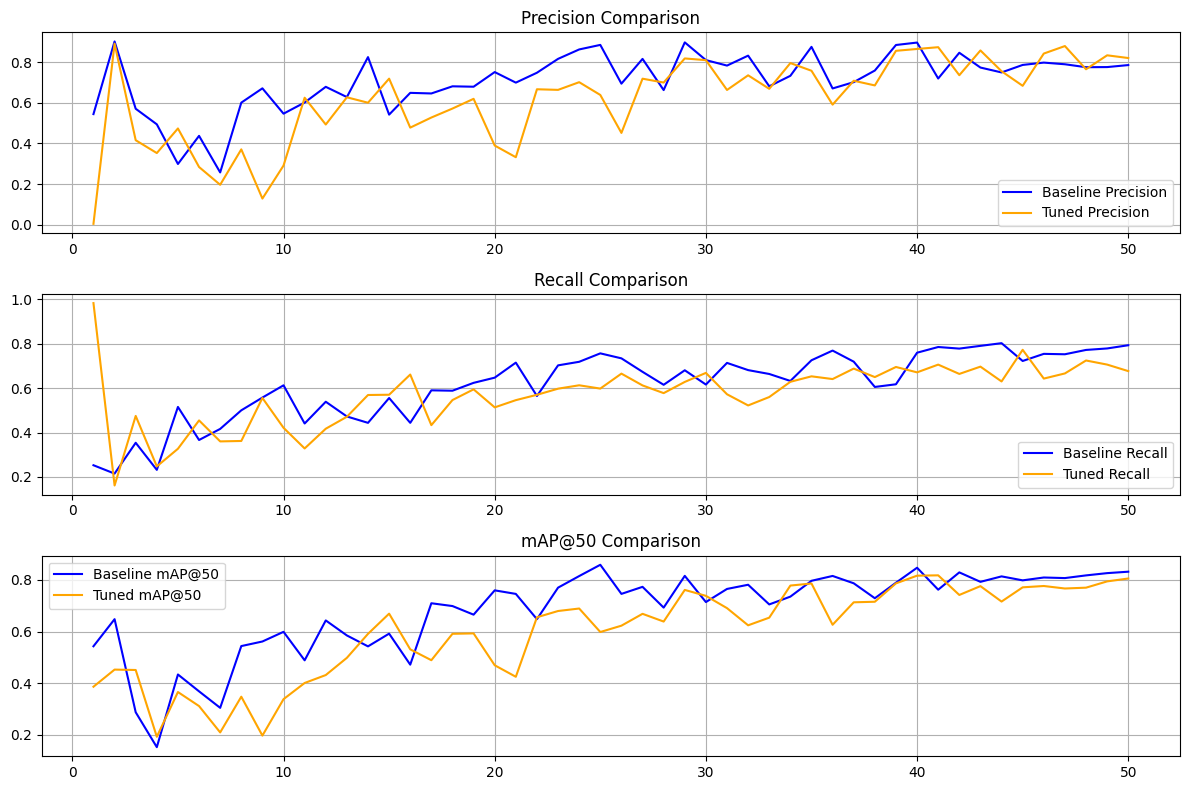

In [34]:

import pandas as pd
import matplotlib.pyplot as plt

baseline_csv = "runs/detect/fall_yolov8n_baseline/results.csv"
tuned_csv = "runs/detect/fall_yolov8n_tuned/results.csv"

baseline_df = pd.read_csv(baseline_csv)
tuned_df = pd.read_csv(tuned_csv)

plt.figure(figsize=(12, 8))

# Plot Precision
plt.subplot(3, 1, 1)
plt.plot(baseline_df["epoch"], baseline_df["metrics/precision(B)"], label="Baseline Precision", color="blue")
plt.plot(tuned_df["epoch"], tuned_df["metrics/precision(B)"], label="Tuned Precision", color="orange")
plt.title("Precision Comparison")
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(3, 1, 2)
plt.plot(baseline_df["epoch"], baseline_df["metrics/recall(B)"], label="Baseline Recall", color="blue")
plt.plot(tuned_df["epoch"], tuned_df["metrics/recall(B)"], label="Tuned Recall", color="orange")
plt.title("Recall Comparison")
plt.legend()
plt.grid(True)

# Plot mAP50
plt.subplot(3, 1, 3)
plt.plot(baseline_df["epoch"], baseline_df["metrics/mAP50(B)"], label="Baseline mAP@50", color="blue")
plt.plot(tuned_df["epoch"], tuned_df["metrics/mAP50(B)"], label="Tuned mAP@50", color="orange")
plt.title("mAP@50 Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Edge/Fail cases**

In [35]:
from ultralytics import YOLO
import os
from IPython.display import Image, display

model_path = "runs/detect/fall_yolov8n_tuned/weights/best.pt"
model = YOLO(model_path)


!mkdir -p runs/detect/fail_cases
model.predict(
    source=f"{MERGED_PATH}/images/test",
    conf=0.25,
    iou=0.5,
    save=True,
    name="fail_cases"
)


result_dir = "runs/detect/fail_cases"
for i, f in enumerate(os.listdir(result_dir)):
    if f.endswith(".jpg") and i < 5:
        display(Image(filename=os.path.join(result_dir, f)))


image 1/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_02_01_jpg.rf.15002eb37ac71dbe6956e583e63ddc8a.jpg: 640x576 1 fallen, 38.4ms
image 2/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_09_01_jpeg.rf.2dc3935abd58cc89697787f361f985a2.jpg: 640x512 1 fallen, 36.3ms
image 3/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_10_01_jpg.rf.7a47d025513afae31e1d06907556ffed.jpg: 640x544 1 fallen, 36.2ms
image 4/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_13_01_png.rf.af23a7b107ce509e04f880490cd253ed.jpg: 448x640 1 fallen, 37.4ms
image 5/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/01_15_01_jpg.rf.455d643274b72a0b837c295c50a05df2.jpg: 448x640 1 fallen, 6.2ms
image 6/18 /content/drive/MyDrive/360_Project/Datasets/fall_dataset/images/test/02_03_01_jpeg.rf.afd2a6040df5d7edc5c8f3df974c2a71.jpg: 640x384 1 sitting, 36.3ms
image 7/18 /content/drive/MyDrive/360_Proje